In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.colors as colors

In [1]:
#@title Animation and Plotting Function (run this)

def animate(ppl_coords, timesteps, ppl_colors = []):
    if len(ppl_colors) == 0:
        ppl_colors = np.zeros((np.shape(ppl_coords)[0], np.shape(ppl_coords)[1]))

    fig = plt.figure()
    axis = plt.axes(xlim =(np.min(ppl_coords[:, :, 0]), np.max(ppl_coords[:, :, 0])), ylim =(np.min(ppl_coords[:, :, 1]), np.max(ppl_coords[:, :, 1])))
    plt.ioff()

    status_colors = ['blue', 'red', 'gray']

    cmap = colors.ListedColormap(status_colors)
    boundaries = np.arange(-0.1, len(status_colors), 1)
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
  
    chart = axis.scatter([], [], c=[], cmap=cmap, norm=norm)
    plt.close(fig)
  
    def init():
        chart.set_offsets(ppl_coords[0])
        chart.set_array(ppl_colors[0])
        return chart,
  
    # animation function
    def animate(i):
        chart.set_offsets(ppl_coords[i])
        chart.set_array(ppl_colors[i])
        return chart,
  
    # calling the animation function    
    anim = animation.FuncAnimation(fig, func = animate,
                              init_func = init,
                              frames = timesteps,
                              interval = 20,
                              blit = False)
  
    return anim

def plot_SIR(susceptible, infected, recovered, timesteps, num_people):
    plt.fill_between(x = np.arange(timesteps), y1 = num_people - np.squeeze(recovered), y2=num_people, color='grey')
    plt.fill_between(x = np.arange(timesteps), y1 = np.squeeze(infected + susceptible), color='blue')
    plt.fill_between(x = np.arange(timesteps), y1 = np.squeeze(infected), color='red') 
    plt.legend(["Recovered", "Susceptible", "Infected"])
    plt.xlabel("Timestep")
    plt.ylabel("Number of People") 

In [2]:
class Person:

    def __init__(self, x, y, speed, dt):
        self.x = x
        self.y = y
        self.speed = speed
        self.dt = dt

    def set_direction(self, angle):
        self.angle = angle
        self.speed_x = self.speed*np.cos(self.angle*np.pi/180)
        self.speed_y = self.speed*np.sin(self.angle*np.pi/180)
  
    def move(self):
        self.x = self.x + self.speed_x * self.dt
        self.y = self.y + self.speed_y * self.dt

    def set_status(self, status):
        # 0 = susceptible, 1 = infected, 2 = recovered
        self.status = status

    def bounce(self, wall):
        if wall == 0:     # Top or bottom wall
            self.set_direction(-1*self.angle)
        elif wall == 1:   # Left or right wall
            self.set_direction(180 - self.angle)

    def set_bounds(self, x_bounds, y_bounds):
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

    def check_bounds(self):
        # Check if the human has intersected or moved past any of the x or y-bounds
        if self.x <= self.x_bounds[0] or self.x >= self.x_bounds[1]:
            self.bounce(1)
        elif self.y <= self.y_bounds[0] or self.y >= self.y_bounds[1]:
            self.bounce(0)

    def set_initial_status(self, prob):
        # Based on the infection probability, set the person's status (hint: use a random number)
        if np.random.random() <= prob:
            self.set_status(1)
            # Begin their recovery if they start sick
            self.init_recovery(0)
        else:
            self.set_status(0)
  
    def distance(self, human2):
        dist = np.sqrt((self.x - human2.x)**2 + (self.y - human2.y)**2)
        return dist

    def init_infection(self, radius, probability, infection_duration):
        # Store the class variables needed for infection to occur
        self.radius = radius
        self.probability = probability
        self.infection_duration = infection_duration

    def infect(self, human2, current_time):
        # Check if human2 is susceptible
        if human2.status != 0:
            return

        # Check if human2 is within the infection radius
        if self.distance(human2) > self.radius:
            return

        # Use random numbers to potentially infect human2
        if np.random.random() <= self.probability:
            human2.status = 1
            human2.init_recovery(current_time)

    def init_recovery(self, infected_time):
        # Store the time at which the person is infected
        self.infected_time = infected_time

    def recover(self, current_time):
        # Check if the person is sick; if they are, and they have been sick for a time exceeding the infection duration, then change their status to be recovered
        if self.status == 1:
            if current_time - self.infected_time >= self.infection_duration:
                self.status = 2
  

### Create Your People
- Create arrays/matrices to store your people, their coordinates, their statuses, and anything else you might want to keep track of during your simulation
- Use a loop to create each person, initialize their variables, and store any information about them that you want access to later 

In [3]:
def init_people(timesteps, num_people, x_bounds, y_bounds, speed, dt, radius, init_prob, transmission_prob, duration):
    # Create array to store all people and matrices to store coordinates and statuses
    people = []
    ppl_coords = np.zeros((timesteps, num_people, 2))
    ppl_colors = np.zeros((timesteps, num_people))

    for i in range(num_people):
        # Define x and y coordinates and angle of movement
        x = np.random.random()*(x_bounds[1]-x_bounds[0]) + x_bounds[0]
        y = np.random.random()*(y_bounds[1]-y_bounds[0]) + y_bounds[0]
        angle = np.random.random()*360

        # Create your person, then set their bounds, then set their direction
        human = Person(x, y, speed, dt)
        human.set_bounds(x_bounds, y_bounds)
        human.set_direction(angle)

        # Set your person's initial infection status using the infection probability constant
        human.set_initial_status(init_prob)

        # Initialize your person's infection variables
        human.init_infection(radius, transmission_prob, duration)

        # Add your person to your array of people
        people.append(human)
  
    return people, ppl_coords, ppl_colors

## Run Your Model
- At each timestep (loop), loop through all people to perform the following:
1. Update their position (and check if they hit a boundary)
2. Store their coordinates and infection status
3. Perform disease transmission if the person is infected
4. Check if the person should recover

In [4]:
def run_model(timesteps, num_people, people, ppl_coords, ppl_colors):
    # Loop through timesteps and people to run model

    ### EDIT THIS ###
    # Create variables to store the number of 1. susceptible, 2. infected, and 3. recovered people at each timestep
    # Hint: Use np.zeros to create a list of zeros that has a length equivalent to the number of timesteps
    # Hint: The syntax for np.zeros is: np.zeros((number_of_timesteps_variable_goes_here, 1)) 

    susceptible = np.zeros((timesteps, 1))
    infected = np.zeros((timesteps, 1))
    recovered = np.zeros((timesteps, 1))

    for i in range(timesteps):
        for j in range(num_people):
            # Get your person from the array of people
            human = people[j]

            # Move your person, then check if they intersected a boundary
            human.move()
            human.check_bounds()

            # Store your person's new coordinates in the matrix of people's coordinates
            ppl_coords[i, j] = np.array([human.x, human.y])

            # Store your person's status in the ppl_colors array
            ppl_colors[i, j] = human.status

            ### EDIT THIS ###
            # Update the count of the number of susceptible, infected, and recovered people for this timestep based on the person's status
            if human.status == 0:
                susceptible[i] += 1
            elif human.status == 1:
                infected[i] += 1
            elif human.status == 2:
                recovered[i] += 1

            # Check if your person is infected, and if so, run the infection function between them and every other person in our model
            if human.status == 1:
                for k in range(num_people):
                    if k != j:
                        human2 = people[k]
                        human.infect(human2, i)

                # Check if your person should recover based on the current time (hint: use our function)
                human.recover(i)

    return susceptible, infected, recovered

### Initialize your model
- Define the number of people you're simulating and for how many timesteps
- Define the infection parameters (radius, initial probability, transmission probability, duration of infection, etc.)
- Define the boundaries that people will be moving within
- Define a speed and timestep (dt) that every person will have 

In [7]:
# Create 50 people and store all of their coordinates for 200 timesteps

# Define the number of timesteps and people
timesteps = 200
num_people = 50

# Define the infection radius, initial infection probability, transmission probability, and infection duration
radius = 1
init_prob = 0.2
transmission_prob = 0.1
duration = 50

# Define the bounds and the matrix to store coordinates for every person at every timestep and status (for color)
x_bounds = [0, 10]
y_bounds = [0, 10]

# Create an array to store all of the people
speed = 1
dt = 0.1

people, ppl_coords, ppl_colors = init_people(timesteps, num_people, 
                                             x_bounds, y_bounds, 
                                             speed, dt, 
                                             radius, init_prob, transmission_prob, duration)

susceptible, infected, recovered = run_model(timesteps, num_people, 
                                             people, ppl_coords, ppl_colors)

### Animate Your Model

In [8]:
anim = animate(ppl_coords, timesteps, ppl_colors)
anim

### Plot Your Data

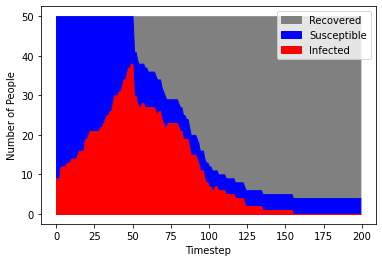

In [9]:
plot_SIR(susceptible, infected, recovered, timesteps, num_people)

### Run Your Model Multiple Times

In [10]:
# Define the number of timesteps and people
timesteps = 200
num_people = 50

# Define the infection radius, initial infection probability, transmission probability, and infection duration
radius = 1
init_prob = 0.05
transmission_prob = 0.1
duration = 50

# Define the bounds and the matrix to store coordinates for every person at every timestep and status (for color)
x_bounds = [0, 10]
y_bounds = [0, 10]

# Create an array to store all of the people
speed = 1
dt = 0.1

### EDIT THIS ###
# Number of times to run the simulation
runs = 50

# Initialize and run the simulation for the defined number of times
# Make sure to collect the data for each run and average it all together to display an average of the SIR graph
susceptible_total = np.zeros((timesteps, 1))
infected_total = np.zeros((timesteps, 1))
recovered_total = np.zeros((timesteps, 1))

for r in range(runs):
  people, ppl_coords, ppl_colors = init_people(timesteps, num_people, 
                                              x_bounds, y_bounds, 
                                              speed, dt, 
                                              radius, init_prob, transmission_prob, duration)

  susceptible, infected, recovered = run_model(timesteps, num_people, 
                                              people, ppl_coords, ppl_colors)
  
  susceptible_total += susceptible
  infected_total += infected
  recovered_total += recovered

susceptible_total /= runs
infected_total /= runs
recovered_total /= runs

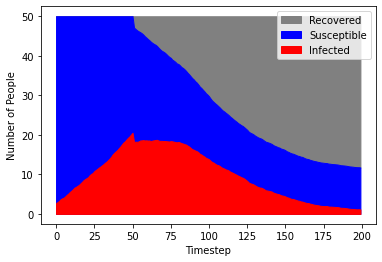

In [11]:
plot_SIR(susceptible_total, infected_total, recovered_total, timesteps, num_people)